# NUMERICAL EXPERIMENTS "Personalized Federated Learning via Active Sampling"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.tree import DecisionTreeRegressor

## A. Toy Dataset

Each local dataset $D^{(i)}$ consists of $m_i$ realizations of i.i.d. random variables with a common probability distribution $p^{(i)}$ (Eq.(9)).

Each data point is characterized by a feature vector $\mathbf{x}^{(i,r)} \in R^d$ and a scalar label $y^{(i,r)}$, for $r = 1,...,m_i$. It would be convenient to stack the feature vectors and labels of a local dataset $D^{(i)}$, into a feature matrix and label vector, respectively (see Eq.(10)).

The feature vectors $\mathbf{x}^{(i,r)} ∼ N(0,I_{d×d})$, are drawn i.i.d. from a standard multivariate normal distribution. The labels $y^{(i,r)}$ of the data points are modeled as a noisy linear combination of the corresponding features $\mathbf{x}^{(i,r)}$ (see Eq.(11)).

The noise $\epsilon^{(i)} ∼ N(0,I)$, for $i ∈ V$ and $r = 1,...,m_i$, are i.i.d. realizations of a standard normal distribution. The noise variance $\sigma^2 ≥ 0$ in (Eq. (11)) is assumed fixed.

In [2]:
class local_ds:
    
    """
    
    Class to create dataset objects. 
    Datasets are noisy Gaussian regression  D^(i) := (X^(i), y^(i)) (see Eq.(11)). 
    
    Args:
    : weights       : array of shape (d, 1), true weight vectors of a cluster
    : cluster_label : scalar, cluster label / id, indicates to which cluster local dataset D^(i) belongs
    : m_i           : scalar, number of samples in a local dataset D^(i)
    : sigma         : scalar, scale of normal distribution used to generate data noise
    
    Out:
    : (X, y) : arrays, local datasets D^(i), feature matrix X and label vector y.
               X shape (m_i, d)
               y shape (m_i, 1)
                               
    """
    
    def __init__(self, weights, cluster_label, m_i, sigma):
        self.weights = weights
        self.cluster_label = cluster_label
        self.d = weights.shape[0]
        self.m_i = m_i
        self.sigma = sigma
        # we generate data on the init of the object
        self.data = self.generate()
  
    def generate(self):
        # when this class method is called, new X, noise and thus y is generated
        # sample feature vectors from multivar Gaussian ~N(0,I)
        X = np.random.normal(0, 1.0, size=(self.m_i, self.d))
        # sample noise 
        noise = np.random.normal(loc=0.0, scale=self.sigma, size=(self.m_i, 1))
        # noisy Gaussian regression, see Eq.(11)
        y = X@self.weights + noise
        return (X, y)  

# Parametric Models (Experiments B-E)

## Configuration

We generate $n = 100$ local datasets according to Eq.(11) with the true underlying parameter $\overline{\mathbf{w}}^{(i)}$ being clustered into two equal-sized 
clusters, $\mathcal{C}_{1}$ and $\mathcal{C}_{2}$ with $n_{1}=n_{2}=50$. 
For each cluster, we generate a parameter vector $\mathbf{w}^{(i)}$ by filling its entries 
with i.i.d. samples of a uniform distribution $\mathcal{U}_{[-5, 5]}$. Each client possesses feature 
vectors (independently and identically sampled from a standard multivariate normal distribution) of size $d$, comprising $m=10$ samples. 
The labels assigned to the data points are modelled as a noisy linear combination of the  respective features and weight vectors unique to each cluster. 

In [3]:
n_clusters = 2
n_ds       = 50
m_i        = 10
eta        = 0.05
R          = 1500
save_data  = False

# plt settings
plt.rcParams.update({'axes.spines.right': False,
                     'axes.spines.top': False})

In [4]:
def weight_update(subset, weights, eta):
    
    """
    Function to compute loss, gradient and weight updates on subset of the clients D^(i´).
    Implements Eqs.(1,13).
    
    Args:
    
    : subset    : tuple (X,y), where X array of shape (B, m_i, d) and y - (B, m_i, 1),
                  randomly selected subset of data (see Line 3 of Algo 1)
    : weights   : array of shape (d, 1), weight vector, w_hat in Eq.(1)
    : eta       : scalar, scaling param, see Eq.(1)

    Out:

    : w_updated : array of shape (B, d), updated weight vector for each dataset D^(i´) in the subset, 
                  w_tilde^(i´) in Eq.(1,4)
    
    """
    
    B, d = len(subset[0]), weights.shape[0]
    
    # Store updated weights
    w_updated = np.zeros((B, d))
    
    # For each dataset D^(i´) in the subset compute updated weight vector w_tilde^(i´) according to Eq.(1)
    for i in range(B):
        # get D^(i´)
        X, y = subset[0][i], subset[1][i]
        # compute local loss L^(i´) incurred by a model parameters w_hat on dataset D^(i´), 
        # loss L^(i´) is defined as in Eq.(13)
        loss = np.mean((y - X@weights)**2)
        # compute gradient \nabla L^(i´)(w_hat) in Eq.(1)
        grad = (-2/len(y))*X.T@(y - X@weights)
        # update weight vector w_hat according to Eq.(1,4)
        w_updated[i] = (weights - eta*grad).reshape(-1,)
    
    return w_updated

def choose_candidate(D1, w_updated):

    """
    Function to determine candidate with smallest loss i_0 on dataset D^(1).
    Implements Eq.(3).
    
    Args:
    
    : D1        : tuple (X,y), dataset D^(1) where X of shape (m_i, d), y - (m_i, 1)
    : w_updated : array of shape (B, d), updated weight vector, w_tilde^(i´) in Eq.(1)

    Out:

    Return weight vector which incur smallest loss on the dataset D^(1) and correponding loss value  
    (i_0 in the paper, see Eq.(3))
    
    """
    
    X, y, m = D1[0], D1[1], len(D1[1])
    errors = y.reshape(1, m) - w_updated@X.T # shape (B, m)
    loss = np.mean(errors**2, axis=1) # shape (B,)
    # determine candidate with a smallest loss on dataset D^(1), Eq.(3) 
    candidate_idx = np.argmin(loss)

    # return weight vector and loss value of the candidate i_0
    return w_updated[candidate_idx].reshape(-1,1), loss[candidate_idx]
    

In [5]:
def train(n_clusters, m_i, d, sigma, R, eta, B, n_ds, regenerate=False, oracle=False):

    """
    Function to create datasets and implement Algorithm 1  "PersFL for Parametric Models".
    
    Args:
    
    : n_clusters  : scalar, number of disjoint clusters
    : m_i         : scalar, sample size of the datasets. We asssume same `m_i` for all datasets.
    : d           : scalar, dimention of the feature vector
    : sigma       : scalar, noise scale, see Eq.(11)
    : R           : scalar, number of iterations
    : eta         : scalar, scaling param eta in Eq.(1)
    : B           : scalar, size of randomly chosen subset of the clients
    : n_ds        : scalar, number of datasets in a cluster 
    : regenerate  : boolean, flag to set if for each dataset in chosen subset (line 3 of Algo1),
                    the feature matrix and lables are resampled 
    
    Out:

    : losses     : array of len (R), loss values on each iteration given by the best candidate, 
                   Eq.(3) l_i0 in the paper
    
    """
    
    # Sample true weight vector for clusters 
    # uniform distr ~U(-5,5)
    true_weights = np.random.uniform(-5, 5, size=(n_clusters, d, 1))

    # Create dataset D_(1) with true weight vector corresponding to the first cluster
    D1 = local_ds(true_weights[0], 0, m_i, sigma).data
    
    # Create client datasets D_(i`) objects 
    Ds = []
    for i in range(n_clusters):
        for j in range(n_ds):
            D = local_ds(true_weights[i], i, m_i, sigma)
            Ds.append(D)
    
    # Init model weights (w_hat:=0 Line 1 of Algo 1)
    weights = np.zeros((d, 1))
    
    # training loop
    MSE = np.zeros((R)) # Eq.(14) compute MSE := ||w_hat - w_true^(1)||^2
    for i in range(R):
        # Line 3 of Algo 1, select a subset of clients
        # from n_clusters*n_ds datasets
        idx = np.random.choice(n_clusters*n_ds, B, replace=False)
        Ds_subset = [Ds[i] for i in idx]
        cluster_ids = np.array([D.cluster_label for D in Ds_subset])
        # get data from dataset objects
        Xs = np.zeros((B, m_i, d))
        ys = np.zeros((B, m_i, 1))
        if regenerate: 
            # on each iteration datasets (X, noise and thus y)
            # are "re-generated" while true weight vectors are as defined above
            for j in range(B):
                X, y = Ds_subset[j].generate()
                Xs[j], ys[j] = X, y
            subset = (Xs, ys) 
        else:
            # access data attribute generated on the dataset object initialization 
            for j in range(B):
                X, y = Ds_subset[j].data
                Xs[j], ys[j] = X, y
            subset = (Xs, ys)           
  
        # Line 4 of Algo 1. Update weight vector w_hat on clients' datasets (according to Eq.(1))
        w_updated = weight_update(subset, weights, eta)
        # Line 5,6 of Algo 1. Compute loss on local dataset D1 and choose best candidate (according to Eq.(3))
        weights, _ = choose_candidate(D1, w_updated)
        
        if oracle:
            # get indices of all local datasets with cluster label 0
            idx_cluster1 = np.where(cluster_ids==0)[0]
            # randomly select updated vector weight from them
            weights = w_updated[np.random.choice(idx_cluster1, 1, replace=False)[0]].reshape(-1,1)
            
        # Eq.(14) compute MSE := ||w_hat - w_true^(1)||^2
        MSE[i] = np.sum((true_weights[0] - weights)**2)  
    return MSE

## B. Training a Personalized Linear Model (Figure 2)

We generated different collections of local datasets by varying the ratio $d/m \in \{ 0.2, 1, 2, 5, 10\}$ between number of features and size of local datasets. 
We measure the quality of the learnt local model parameter $\widehat{\mathbf{w}}^{(i)}$ using the squared Euclidean norm 
$
\begin{equation}
{\rm MSE} = ||{\widehat{\mathbf{w}}-  \overline{\mathbf{w}}^{(1)}}||_{2}^{2}
\end{equation}
$

### Figure 2a - Different d/m ratio (noise=0, B=20)

In [6]:
# Algo 1 with different d/m ratio
def experiment(n_clusters, n_ds, m_i, eta, R, regenerate=False, oracle=False):
    # params of experiment
    sigma = 0
    B  = 20
    
    # try out different d/m ratios (keep m=10 and vary d)
    # d/m = 0.2, 1, 2, 5, 10 ~> d = 2, 10, 20, 50, 100
    ds = [2, 10, 20, 50, 100]
    
    mse = np.zeros((len(ds), R))
    for i, d in enumerate(ds):  
        mse[i] = train(n_clusters, m_i, d, sigma, R, eta, B, n_ds, regenerate, oracle)
    
    labels = ['d/m = 0.2', 'd/m = 1', 'd/m = 2', 'd/m = 5', 'd/m = 10']
    for i in range(len(ds)):
        plt.plot(np.arange(R), mse[i], label=labels[i])
        
    plt.xlabel('R')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.title('Algorithm 1 MSE w.r.t. d/m ratio')
    plt.show()
    return mse

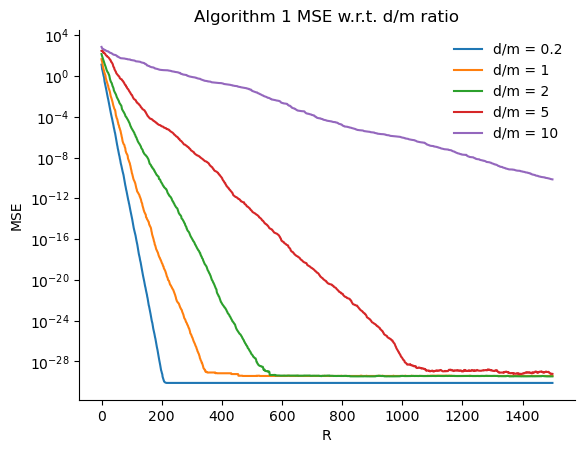

In [7]:
mse = experiment(n_clusters, n_ds, m_i, eta, R)
if save_data:
    df = pd.DataFrame(data=mse.T)
    df.to_csv('Algo1_dm_ratio.csv', mode='a', index=True, header=None)

### Figure 2b - Different noise levels (d/m=2, B=20)

In [8]:
# Algo 1 with different values for noise
def experiment(n_clusters, n_ds, m_i, eta, R, regenerate=False, oracle=False):
    # params of experiment
    d = 20
    B = 20
    
    # try out different noise levels
    noise = [0.05, 0.1, 0.2, 0.5, 1.0]
    
    mse = np.zeros((len(noise), R))
    for i, sigma in enumerate(noise):
        mse[i] = train(n_clusters, m_i, d, sigma, R, eta, B, n_ds, regenerate, oracle)
    
    labels = [r'$\sigma$ = 0.05', r'$\sigma$ = 0.1', r'$\sigma$ = 0.2', r'$\sigma$ = 0.5', r'$\sigma$ = 1.0']
    for i in range(len(noise)):
        plt.plot(np.arange(R), mse[i], label=labels[i])
        
    plt.xlabel('R')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.title(r'Algorithm 1 MSE w.r.t. $\sigma$')
    plt.show()
    return mse

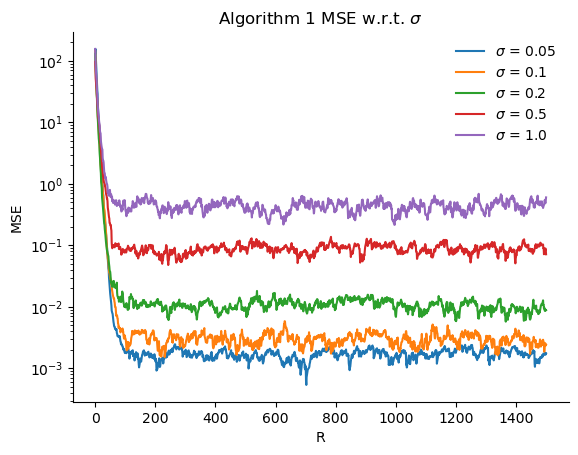

In [9]:
mse = experiment(n_clusters, n_ds, m_i, eta, R)
if save_data:
    df = pd.DataFrame(data=mse.T)
    df.to_csv('Algo1_noise.csv', mode='a', index=True, header=None)

### Figure 2c - Different subset size B (d/m=2, noise=0)

In [10]:
# repeat experiment with different values for subset size
def experiment(n_clusters, n_ds, m_i, eta, R, regenerate=False, oracle=False):
    # params of experiment
    d = 20
    sigma = 0
    
    # try out different B
    Bs = [5, 10, 15, 20, 30]
    
    mse = np.zeros((len(Bs), R))
    for i, B in enumerate(Bs):
        mse[i] = train(n_clusters, m_i, d, sigma, R, eta, B, n_ds, regenerate, oracle)
    
    labels = ['B = 5', 'B = 10', 'B = 15', 'B = 20', 'B = 30']
    for i in range(len(Bs)):
        plt.plot(np.arange(R), mse[i], label=labels[i])
    
    plt.xlabel('R')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.ylim(10e-36, 10e5)
    plt.legend(frameon=False)
    plt.title(r'Algorithm 1 MSE w.r.t. subset size $B$')
    plt.show()
    return mse

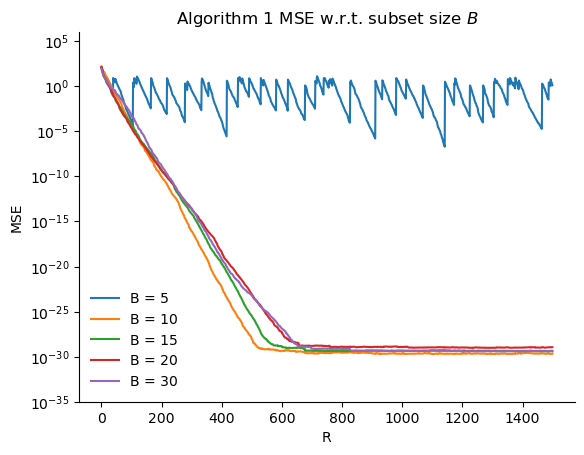

In [11]:
mse = experiment(n_clusters, n_ds, m_i, eta, R)
if save_data:
    df = pd.DataFrame(data=mse.T)
    df.to_csv('Algo1_B.csv', mode='a', index=True, header=None)

## C. Comparison with IFCA (Figure 3,4) 

In [12]:
def compute_grads(subset, weights):
    
    """
    
    Function to compute cluster identity estimate, gradients and loss.
    Implements Lines 5-9 of Algo 2 "Iterative Federated Clustering Algorithm (IFCA)".
    
    Args:
    
    : subset  : tuple (X,y), where X of shape (B, m_i, d), y - (B, m_i, 1),
                randomly selected subset of data
    : weights : array of shape (n_clusters, d), cluster weight vectors, theta^t_j

    Out:

    : cluster_labels : array of shape (n_clients), estimated cluster identity
    : grads          : array of shape (n_clients, d), gradient corresponding to chosen cluster identity
    : l              : array of shape (n_clients), loss corresponding to chosen cluster identity
    
    """
    
    Xs, ys = subset[0], subset[1]
    n_clients, m, n_clusters, d = ys.shape[0], ys.shape[1], weights.shape[0], weights.shape[1]
    
    cluster_labels = np.zeros((n_clients))
    # for each weight vector/cluster compute loss and gradient
    loss = np.zeros((n_clients, n_clusters))
    gradients = np.zeros((n_clients, n_clusters, d))
    for i in range(n_clients):
        X, y =  Xs[i], ys[i]
        for j in range(n_clusters):
            loss[i, j] = np.mean((y - X@weights[j].reshape(-1,1))**2)
            gradients[i, j] = ( (-2/m)*X.T@(y - X@weights[j].reshape(-1,1)) ).reshape(-1,)

    # compute which weights/ cluster are giving smaller loss
    cluster_labels = np.argmin(loss, axis=1) 
    # select corresponding gradient and loss value
    grads = np.zeros((n_clients, d))
    l = np.zeros((n_clients))
    
    for i in range(n_clients) : grads[i] = gradients[i, cluster_labels[i]]
    for i in range(n_clients) : l[i] = loss[i, cluster_labels[i]]

    return cluster_labels, grads, l

In [24]:
def ifca(n_clusters_true, n_clusters_exp, m_i, d, sigma, R, eta, B, n_ds, regenerate=False):

    """
    Function to create datasets and implement Algorithm 2 "Iterative Federated Clustering Algorithm (IFCA)".
    
    Args:
    
    : n_clusters_true : scalar, true number of disjoint clusters
    : n_clusters_exp  : scalar, expected number of disjoint clusters, k in Algo 2
    : m_i             : scalar, sample size of the datasets, denoted m in Algo 2. We asssume same m for all datasets.
    : d               : scalar, dimention of the weight vector
    : sigma           : scalar, noise scale
    : R               : scalar, number of iterations, T in Algo 2
    : eta             : scaling param, scalar, gamma in Algo 2
    : B               : scalar, size of randomly chosen subset of the clients
    : n_ds            : scalar, number of datasets in a cluster
    : regenerate      : boolean, flag to set if for each dataset in chosen subset (line 3 of Algo1),
                        the feature matrix and lables are resampled 
    Out:

    : losses     : array of len (R), MSE incured on dataset D^(1) on each iteration 
                   by model with weight vector theta^(t+1)_j (see Line 14 of Algo 2)
    
    """

    # Sample true weight vector for clusters
    # uniform distr ~U(-5,5)
    true_weights = np.random.uniform(-5, 5, size=(n_clusters_true, d, 1))
    
    # Create dataset D_(1) with true weight vector corresponding to the first cluster
    X1, y1 = local_ds(true_weights[0], 0, m_i, sigma).generate()
    X1, y1 = X1.reshape(1,m_i,d), y1.reshape(1,m_i,1)
    
    # Create client datasets D_(i`) objects 
    Ds = []
    for i in range(n_clusters_true):
        for j in range(n_ds):
            D = local_ds(true_weights[i], i, m_i, sigma)
            Ds.append(D)

    # init clusters weights
    weights = np.random.normal(0, 1.0, size=(n_clusters_exp, d))
    
    # store MSE := ||w_hat - w_true^(1)||^2
    MSE = np.zeros((R))         

    for iter in range(R): # Line 2.
        # Line 4. Select subset of clients:
        idx = np.random.choice(n_clusters_true*n_ds, B, replace=False)
        Ds_subset = [Ds[i] for i in idx]
        # get data from dataset objects
        Xs = np.zeros((B, m_i, d))
        ys = np.zeros((B, m_i, 1))
        if regenerate: 
            # on each iteration datasets (X, noise and thus y)
            # are "re-generated" while true weight vectors are as defined above
            for j in range(B):
                X, y = Ds_subset[j].generate()
                Xs[j], ys[j] = X, y
            subset = (Xs, ys)  
        else:
            # access data attribute generated on the dataset object initialization 
            for j in range(B):
                X, y = Ds_subset[j].data
                Xs[j], ys[j] = X, y
            subset = (Xs, ys)   

        # Lines 5-9. for each client in the subset compute cluster estimate and corresponding gradient 
        cluster_labels, grads, _ = compute_grads(subset, weights)
        
        # Line 14. compute average of the gradients over the clusters and update weights
        for i in range(n_clusters_exp):
            # choose all clients with cluster label i
            idx = np.where(cluster_labels == i)[0]
            if len(idx) != 0:
                # average gradient over cluster i
                grad_aver = np.mean(grads[idx], axis=0)
                # update weight vector for the corresponding cluster
                weights[i] = weights[i] - eta*grad_aver
        
        # compute loss for the 1st client (to compare with persFL algo):
        # 1. get cluster label
        cluster_labels, _, _ = compute_grads((X1, y1), weights)
        c1 = cluster_labels[0]
        # 2. compute loss given learnt weight vector, MSE := ||w_hat - w_true^(1)||^2
        MSE[iter] = np.mean((true_weights[0] - weights[c1].reshape(-1,1))**2)
    return MSE

In [25]:
def experiment(n_clusters_true, n_clusters_exp, n_ds, m_i, eta, R, regenerate=False):
    # params of experiment
    B = int(0.2*n_clusters_true*n_ds)
    sigma = 0

    # try out different d/m ratios (keep m=10 and vary d)
    # d/m = 0.2, 1, 2, 5, 10 ~> d = 2, 10, 20, 50, 100
    ds = [2, 20, 50]
    labels = ['d/m = 0.2', 'd/m = 2', 'd/m = 5']
    
    mse = np.zeros((len(ds), R))
    mse_ifca = np.zeros((len(ds), R))
    for i, d in enumerate(ds):  
        mse[i] = train(n_clusters_true, m_i, d, sigma, R, eta, B, n_ds, regenerate=regenerate)
        mse_ifca[i] = ifca(n_clusters_true, n_clusters_exp, m_i, d, sigma, R, eta, B, n_ds)

    fig, axs = plt.subplots(1, len(ds), figsize=(12,4))
    for i in range(len(ds)):
        axs[i].plot(np.arange(R), mse[i], label='algo 1')
        axs[i].plot(np.arange(R), mse_ifca[i], label='ifca')
        axs[i].set_title(labels[i])
        axs[i].set_yscale('log')

    plt.xlabel('R')
    plt.ylabel('MSE')
    plt.legend(frameon=False)
    plt.show()
    return mse, mse_ifca

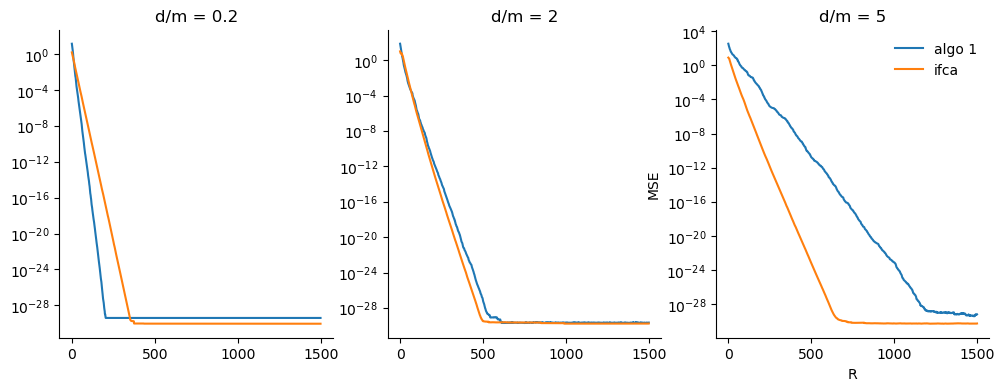

In [15]:
loss_algo1, loss_ifca = experiment(n_clusters, n_clusters, n_ds, m_i, eta, R)

In [16]:
if save_data:
    df = pd.DataFrame(data=loss_algo1.T)
    df_ifca = pd.DataFrame(data=loss_ifca.T)
    df.to_csv('Algo1vsIfca_Algo1_baseline.csv', mode='a', index=True, header=None)
    df_ifca.to_csv('Algo1vsIfca_ifca_baseline.csv', mode='a', index=True, header=None)

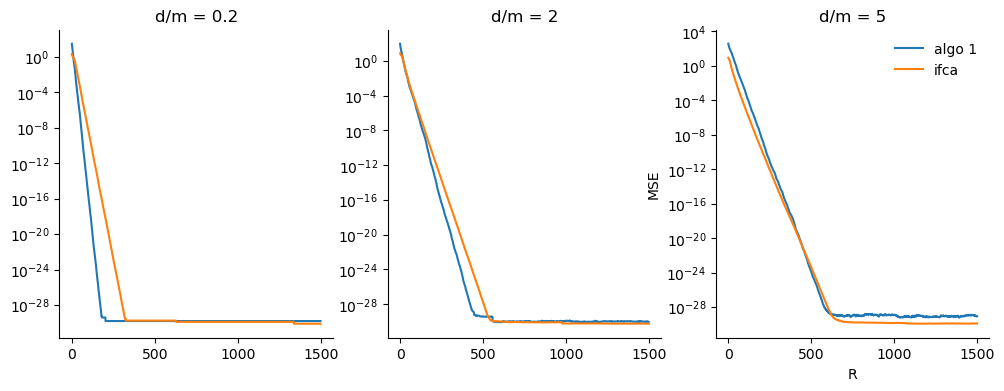

In [18]:
_, _ = experiment(n_clusters, n_clusters, n_ds, m_i, eta, R, regenerate=True)

**Varying true nr of clusters and assumed nr of clusters for ifca**

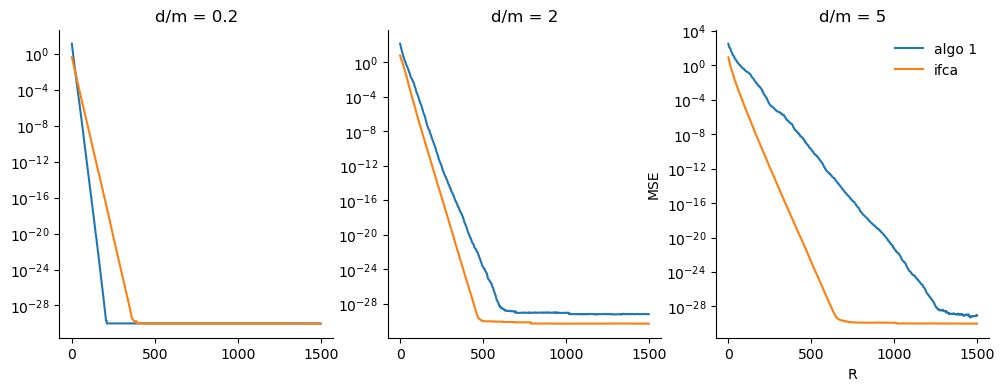

In [35]:
_, _ = experiment(2, 5, n_ds, m_i, eta, R)

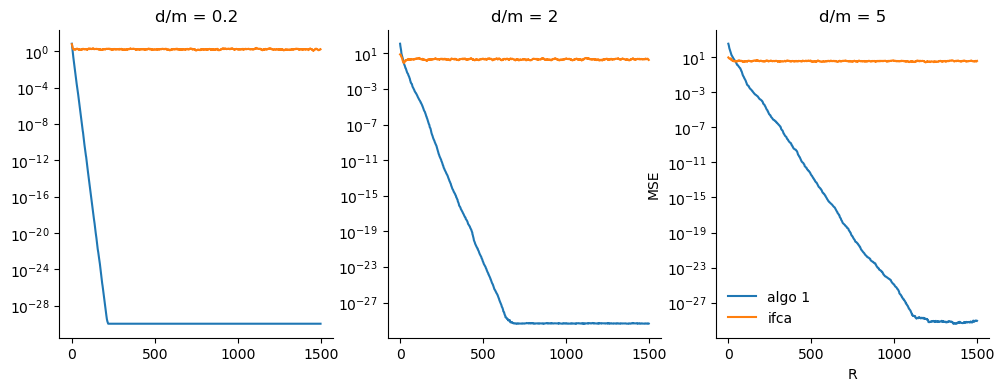

In [34]:
_, _ = experiment(3, 2, n_ds, m_i, eta, R)

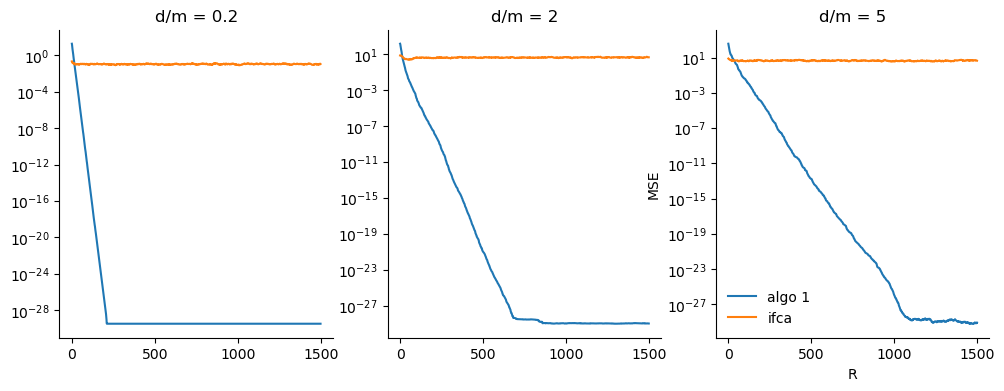

In [36]:
loss_algo1, loss_ifca = experiment(5, 2, n_ds, m_i, eta, R)

In [37]:
if save_data:
    df = pd.DataFrame(data=loss_algo1.T)
    df_ifca = pd.DataFrame(data=loss_ifca.T)
    df.to_csv('Algo1vsIfca_Algo1_cl_mismatch.csv', mode='a', index=True, header=None)
    df_ifca.to_csv('Algo1vsIfca_ifca_cl_mismatch.csv', mode='a', index=True, header=None)

## D. Comparison with Oracle Method (Figure 5) 

This experiment compares the performance of Algorithm 1 against oracle approach which has perfect knowledge about the cluster structure. Instead of the candidate selection rule in line 6 of Algorithm 1, the oracle approach randomly samples a node $i' \in \mathcal{C}$ from the correct cluster (same cluster as $\mathcal{D}^{(1)}$).


In [38]:
def experiment(n_clusters, n_ds, m_i, eta, R):
    # params of experiment
    sigma = 0
    B     = 20
    d     = 20

    mse = train(n_clusters, m_i, d, sigma, R, eta, B, n_ds)
    mse_oracle = train(n_clusters, m_i, d, sigma, R, eta, B, n_ds, oracle=True)
    
    plt.plot(np.arange(R), mse, label='Algo1')
    plt.plot(np.arange(R), mse_oracle, label='Algo1 Oracle')
        
    plt.xlabel('R')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.title('Algorithm 1 MSE vs oracle')
    plt.show()
    return mse, mse_oracle

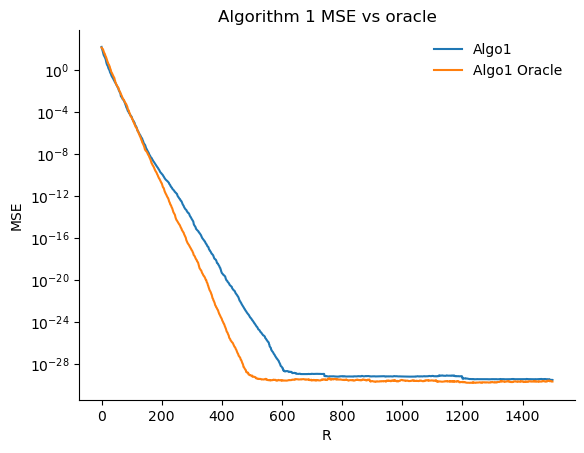

In [39]:
mse, mse_oracle = experiment(n_clusters, n_ds, m_i, eta, R)
if save_data:
    df = pd.DataFrame(data=np.array([mse, mse_oracle]).T)
    df.to_csv('Algo1_oracle.csv', mode='a', index=True, header=None)

## E. Online Learning of Personalized Linear Model (Figure 6) 

In this experiment we analyze performance of Algorithm 1 with modified sampling procedure (see line 3 of Algorithm 1). Specifically, on each iteration for all local datasets $\mathcal{D}^{(i)}$ in a randomly chosen subset $\mathcal{S}$ we resample new feature matrix $\mathbf{X}^{(i)}$ and label vector  $\mathbf{y}^{(i)}$, while keeping the true weight vector $\mathbf{\overline{w}}^{(i)}$ unchanged.

In [40]:
def experiment(n_clusters, n_ds, m_i, eta, R, regenerate=False, oracle=False):
    # params of experiment
    sigma = 0
    B     = 20
    
    # try out different d/m ratios (keep m=10 and vary d)
    # d/m = 0.2, 1, 2, 5, 10 ~> d = 2, 10, 20, 50, 100
    ds = [2, 10, 20, 50, 100]
    
    mse = np.zeros((len(ds), R))
    for i, d in enumerate(ds):  
        mse[i] = train(n_clusters, m_i, d, sigma, R, eta, B, n_ds, regenerate, oracle)
    
    labels = ['d/m = 0.2', 'd/m = 1', 'd/m = 2', 'd/m = 5', 'd/m = 10']
    for i in range(len(ds)):
        plt.plot(np.arange(R), mse[i], label=labels[i])
        
    plt.xlabel('R')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.title('Algorithm 1 MSE w.r.t. d/m ratio')
    plt.show()
    return mse

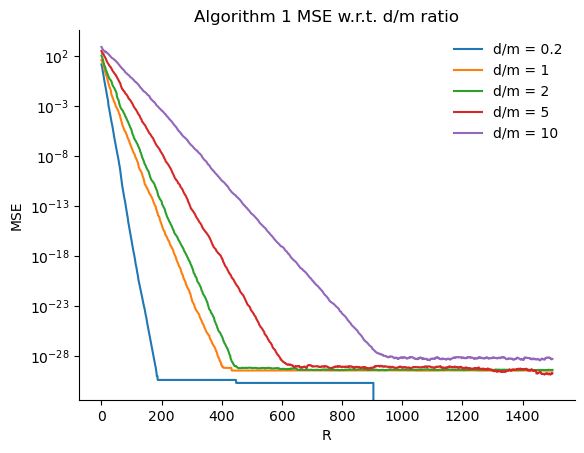

In [41]:
# Save data as csv
mse = experiment(n_clusters, n_ds, m_i, eta, R, regenerate=True)
if save_data:
    df = pd.DataFrame(data=mse.T)
    df.to_csv('Algo_1_resample.csv', mode='a', index=True, header=None)

# Non-parametric Models (Experiments F)

This section presents experiments conducted using Algorithm 2 and python library scikit-learn. We generate $n = 100$ local datasets according to Eq.(11) with the true underlying parameter vector $\mathbf{\overline{w}}^{(i)}$. Local datasets are clustered into two equal-sized clusters, $\mathcal{C}_{1}$ and $\mathcal{C}_{2}$ with $n_{1}=n_{2}=50$.
For each cluster, we generate a parameter vector $\mathbf{w}^{(i)}$ by filling its entries 
with i.i.d. samples of a uniform distribution $\mathcal{U}_{[-5, 5]}$. Each client possesses feature 
vectors (independently and identically sampled from a standard multivariate normal distribution) of size $d$, comprising $m=10$ samples. 
For the first client we generate local dataset $\mathcal{D}_{1}$ consisting of training $\mathcal{D}_{train}^{(1)}$ and validation $\mathcal{D}_{val}^{(1)}$ sets of sizes $m_{train} = 10$ and $m_{val} = 100$. 

As model we use decision tree regressor implemented with python library scikit-learn. We implement line 4 of Algorithm 1, computing regularized local loss as defined in Eq.(7), by constructing augmented local dataset. Augmented dataset is the local dataset $\mathcal{D}^{(i')}$ augmented by the data points $(\mathbf{x},\widehat{h}((\mathbf{x}))$, $\mathbf{x} \in \mathcal{D}^{(t)}$, see also Figure 1.

Each data point $i \in \mathcal{D}^{(t)}$ in dataset is characterized by a feature vector $\mathbf{x}^{(i)} $ drawn i.i.d. from a standard multivariate normal distribution $\mathbf{x}^{(i)} \sim N(0,I)$. The size of the dataset $\mathcal{D}^{(t)}$ is set to $m_t=100$.

We initialize hypothesis $\widehat{h}$ by fitting decision tree regressor to the training set of the first client $\mathcal{D}_{train}^{(1)}$.
To pass regularization parameter $\eta$ in Eq.(7) to the training function, we use provided function argument called sample weight (see documentation https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.fit). The regularization parameter value is set to $\eta=1$.

We also train oracle model on all $n=50$ local datasets belonging to the same cluster as first client's dataset $\mathcal{D}^{(1)}$. 
 
To measure the quality of the learnt local model $\widehat h$ we use normalized squared Euclidean norm 

$
\begin{equation}
{\rm MSE_{norm}} =	\frac{\rm MSE}{\rm MSE_{oracle}}
\end{equation}
$

where $\rm MSE$ is defined as

$
\begin{equation}
{\rm MSE} =	\sum_{i=1}^{m_{val}} ||{\widehat h(\mathbf{x}_{val}^{(i)}) -  \mathbf{y}_{val}^{(i)}}||_{2}^{2}
\end{equation}
$

and 

$
\begin{equation}
	\mathcal{D}_{val}^{(1)} = \bigg\{ \left({\mathbf{x}_{val}^{(i)}}, \mathbf{y}_{val}^{(i)} \right), ..., \left({\mathbf{x}_{val}^{(m_{val})}}, \mathbf{y}_{val}^{(m_{val})} \right)  \bigg\}
\end{equation}
$

$\rm MSE_{oracle}$ is MSE loss of oracle model incurred on the validation set $\mathcal{D}_{val}^{(1)}$.

We run experiment for different values of data dimensionality $d = \{2,10,20,50,100 \}$. In addition to ${\rm MSE_{norm}}$ defined above (solid lines in the plot below), we also plot normalized MSE values for the model trained locally, i.e. only on training set $\mathcal{D}_{train}^{(1)}$. These normalized MSE values are depicted with dashed lines in the plot with colors corresponding to a certain $d/m_i$ ratio.

## Configuration

In [42]:
n_clusters = 2
n_ds       = 50
m_i        = 10
save_data  = False

In [43]:
def create_aug_ds(local_ds, X_test, h_hat, eta):

    """
    Function to create augmented dataset, i.e. local dataset stacked with global test set (D^(t), h_hat(D^(t))), 
    see Eq.(6).
    
    Arg:
    : local_ds : tuple of two arrays (X,y) of shapes X (m_i, d), y (m_i, 1)
    : X_test   : array of shape (m_test, d)
    : h_hat    : sklrean model instance
    : eta      : scalar, sample weight for test datapoints

    Out:
    : X_aug         : array of shape (m_i + m_i_test, d), augmented dataset
    : y_aug         : array of shape (m_i + m_i_test), augmented dataset
    : sample_weight : array of shape (m_i + m_i_test,), sample weights for sklearn model
    
    """

    X, y = local_ds[0], local_ds[1]
    y_test = h_hat.predict(X_test)
    
    # Construct augmented dataset
    X_aug = np.concatenate((X, X_test), axis=0)
    y_aug = np.concatenate((y, y_test.reshape(-1,1)), axis=0)
    
    # Set sample weights
    m, m_test = y.shape[0], y_test.shape[0]
    sample_weight = np.concatenate((np.ones((m,)), np.ones((m_test,))*eta))   
    
    return X_aug, y_aug, sample_weight

In [44]:
def get_oracle(Xs, ys, cluster_ids, oracle_model):
    
    """
    Function which takes in local datasets and untrained model and 
    returns a model fit to pooled local datasets with cluster label = 0.
    
    Args:

    : Xs and ys    : arrays, local datasets D^(i'). Xs shape (n_clients, m_i, d); ys shape (n_clients, m_i, 1)
    : cluster_ids  : array of shape (n_clients,), cluster labels
    : oracle_model : sklrean model instance
    
    Out:
    : oracle_model : sklrean model instance fit to the local datasets with cluster label = 0 (1st cluster).
    
    """
    
    m_i, d = Xs[0].shape[0], Xs[0].shape[1]
    # find indices of clients from 1st cluster
    idx = np.where(cluster_ids == 0)
    X, y = Xs[idx].reshape(-1, d), ys[idx].reshape(-1,)
    oracle_model.fit(X, y)
    
    return oracle_model

In [45]:
def train(n_clusters, m_i, d, B, sigma, R, eta, n_ds=None, regenerate=False, **kwargs):

    """
    
    Function to create datasets and implement Algorithm 1  "PersFL for Parametric Models".
    
    Args:
    
    : n_clusters : scalar, number of disjoint clusters
    : m_i        : scalar, sample size of the datasets. We asssume same `m_i` for all datasets.
    : d          : scalar, dimention of the feature vector
    : B          : scalar, size of randomly chosen subset of the clients
    : sigma      : scalar, noise scale, see Eq.(11)
    : R          : scalar, number of iterations
    : eta        : scaling param, scalar, see Eq.(7)
    : n_ds       : scalar, number of datasets in a cluster (used if `regenerate=False`)
    : regenerate : boolean, flag to set if subset is selected from fixed number (n_clusters*n_ds) of local datasets
                    (`regenerate=False`) or on each iteration datasets in a subset are re-sampled (`regenerate=True`)
    : **kwargs   : key args to pass to sklearn model
    
    Out:

    : losses     : array of len (R), loss values on each iteration given by the best candidate, 
                   Eq.(8) l_i0 in the paper

    """

    if regenerate==False: assert n_ds!=None
    
    # Sample true weight vector for clusters 
    # uniform distr ~U(-5,5)
    true_weights = np.random.uniform(-5, 5, size=(n_clusters, d, 1))

    # Create dataset D_(1) with true weight vector corresponding to the first cluster
    # Split validation set (size = 100) as DT overfit very easily
    # and we dont have "true" parameter vector for tracking loss/ error
    X1, y1 = local_ds(true_weights[0], 0, m_i+100, sigma).generate()
    X_1_train, y_1_train = X1[:m_i], y1[:m_i]
    X_1_val, y_1_val = X1[m_i:], y1[m_i:]

    # Create client datasets D_(i`) objects 
    Ds = []
    Xs, ys = np.zeros((n_clusters*n_ds, m_i, d)), np.zeros((n_clusters*n_ds, m_i, 1))
    for i in range(n_clusters):
        for j in range(n_ds):
            # init dataset object
            D = local_ds(true_weights[i], i, m_i, sigma)
            # access data attribute generated on the dataset object initialization 
            X, y = D.data
            Xs[i*n_ds+j], ys[i*n_ds+j] = X, y
            Ds.append(D)
    cluster_ids = np.array([D.cluster_label for D in Ds])

    # init model for client 1
    model_1 = DecisionTreeRegressor(**kwargs)
    model_1.fit(X_1_train, y_1_train.reshape(-1,))
    # baseline loss (only fit to local training data and compute loss on validation set)
    loss_baseline = np.mean((y_1_val - (model_1.predict(X_1_val)).reshape(-1,1))**2)

    # Oracle model
    # fit on n_ds pooled local datasets with cluster lable = 0
    oracle_model = DecisionTreeRegressor(**kwargs)
    oracle_model = get_oracle(Xs, ys, cluster_ids, oracle_model)
    loss_oracle = np.mean((y_1_val - (oracle_model.predict(X_1_val)).reshape(-1,1))**2) 

    # Shared dataset   
    X_test = np.random.normal(0, 1.0, size=(100, d))

    # save loss of best candidate on each iter
    loss_R = np.zeros((R))
    for itr in range(R):
        # Select subset of clients:
        idx = np.random.choice(n_clusters*n_ds, B, replace=False)
        if regenerate: 
            # on each iteration datasets (X, noise and thus y)
            # are "re-generated" while true weight vectors are as defined above
            Ds_subset = [Ds[i] for i in idx]
            Xs = np.zeros((B, m_i, d))
            ys = np.zeros((B, m_i, 1))
            for j in range(B):
                X, y = Ds_subset[j].generate()
                Xs[j], ys[j] = X, y
            subset = (Xs, ys) 
        else:
            subset = (Xs[idx], ys[idx])

        # create DTregressor instances for clients in a subset
        models = [DecisionTreeRegressor(**kwargs) for i in range(B)]
        # save loss for each client in the subset
        loss = np.zeros((B))
        for k in range(B):
            # get augmented dataset
            X_aug, y_aug, sample_weight = create_aug_ds((subset[0][k], subset[1][k]), X_test, model_1, eta)
            # fit model to aug dataset
            models[k].fit(X_aug, y_aug.reshape(-1,), sample_weight=sample_weight)
            # compute loss on D_(1) training subset
            preds = models[k].predict(X_1_train)
            loss[k] = np.mean((y_1_train - preds.reshape(-1,1))**2)
        
        # determine candidate with a smallest D1 training loss 
        candidate_idx = np.argmin(loss)
        model_1 = models[candidate_idx]
        
        # compute loss on validation dataset
        preds_val = model_1.predict(X_1_val)
        loss_R[itr] = np.mean((y_1_val - preds_val.reshape(-1,1))**2)
    return loss_R, loss_baseline, loss_oracle
    

## F. Training a Personalized Decision Tree (Figure 7)

### Different d/m ratio (noise=0, B=20)

In [46]:
def experiment(n_clusters, n_ds, m_i, regenerate=False, **kwargs):
    # other params of experiment
    R     = 500
    sigma = 0
    eta   = 1
    B     = 20
    
    # try out different d/m ratios (keep m=10 and vary d)
    # d/m = 0.2, 1, 2, 5, 10 ~> d = 2, 10, 20, 50, 100
    ds = [2, 10, 20, 50, 100]
    cs = ['b', 'g', 'r', 'c', 'm']

    params_len = len(ds)
    mse = np.zeros((params_len, R))
    baselines = np.zeros((params_len))
    loss_oracle = np.zeros((params_len))
    
    for i, d in enumerate(ds):
        mse[i], baselines[i], loss_oracle[i] = train(n_clusters, m_i, d, B, sigma, R, eta, n_ds, regenerate, **kwargs)
    
    labels = ['d/m = 0.2', 'd/m = 1', 'd/m = 2', 'd/m = 5', 'd/m = 10']
    for i in range(params_len):
        plt.plot(np.arange(R), mse[i]/loss_oracle[i], c=cs[i], label=labels[i])
        plt.axhline(y = baselines[i]/loss_oracle[i], c=cs[i], ls='--')
        plt.axhline(y=1, ls='--', c='k')
        
    plt.xlabel('R')
    plt.ylabel('realative MSE')
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.title('Algorithm 2, realtive MSE w.r.t. d/m ratio')
    plt.show()
    return mse, baselines, loss_oracle

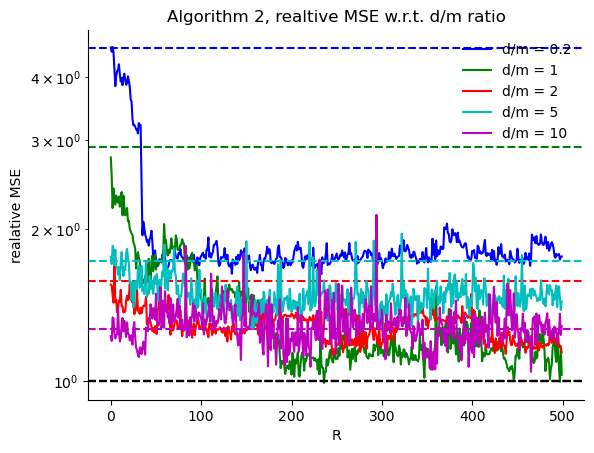

In [47]:
mse, baselines, loss_oracle = experiment(n_clusters, n_ds, m_i, regenerate=False, max_depth=3)
if save_data:
    df = pd.DataFrame(data=(mse/loss_oracle.reshape(-1,1)).T)
    df.to_csv('Algo_2_mse.csv', mode='a', index=True, header=None)

    df = pd.DataFrame(data=np.tile(baselines/loss_oracle, [2,]).reshape(2,-1))
    df[5] = [-10,510]
    df = df.set_index(5)
    df.to_csv('Algo_2_mse_baseline.csv', mode='a', index=True, header=None)

### Different sample weight (regularization term), noise=0, B=20, d/m=2

In [48]:
def experiment(n_clusters, n_ds, m_i, regenerate=False, **kwargs):
    # other params of experiment
    R     = 500
    d     = 20
    sigma = 0
    B     = 20
    
    # try out different reg.term / sample weight
    etas = [0, 1, 10, 50]
    cs = ['b', 'g', 'r', 'c']
    
    params_len = len(etas)
    mse = np.zeros((params_len, R))
    baselines = np.zeros((params_len))
    loss_oracle = np.zeros((params_len))
    
    for i, eta in enumerate(etas): 
        mse[i], baselines[i], loss_oracle[i] = train(n_clusters, m_i, d, B, sigma, R, eta, n_ds, regenerate, **kwargs)
    
    labels = ['reg.term = 0', 'reg.term = 1', 'reg.term = 10', 'reg.term = 50']
    for i in range(params_len):
        plt.plot(np.arange(R), mse[i]/loss_oracle[i], c=cs[i], label=labels[i])
        plt.axhline(y = baselines[i]/loss_oracle[i], c=cs[i], ls='--')
        plt.axhline(y=1, ls='--', c='k')
        
    plt.xlabel('R')
    plt.ylabel('relative MSE')
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.title('Algorithm 2, realtive MSE w.r.t. sample weight')
    plt.show()    

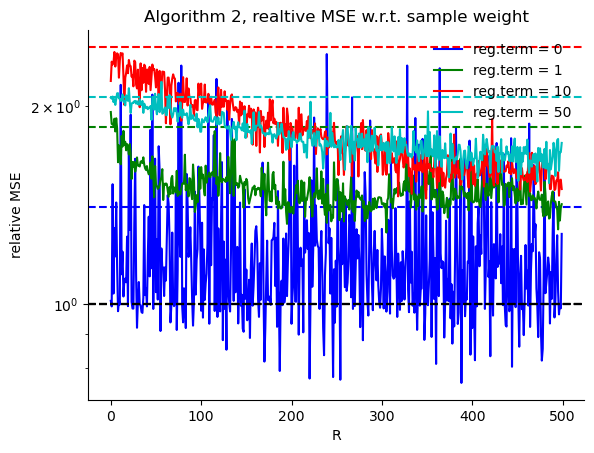

In [49]:
experiment(n_clusters, n_ds, m_i, regenerate=False, max_depth=3)

### Different max_depth (d/m=2, B=20)

In [50]:
def experiment(n_clusters, n_ds, m_i, regenerate=False, **kwargs):
    R     = 500
    d     = 20
    sigma = 0
    eta   = 1
    B     = 20

    # try out different max_depth
    max_depths = [3, 5, 10]
    cs = ['b', 'g', 'r', 'c']
    
    params_len = len(max_depths)
    mse = np.zeros((params_len, R))
    baselines = np.zeros((params_len))
    loss_oracle = np.zeros((params_len))
    
    for i, max_depth in enumerate(max_depths):
        mse[i], baselines[i], loss_oracle[i] = train(n_clusters, m_i, d, B, sigma, R, eta, n_ds, regenerate, **{'max_depth': max_depth})
    
    labels = ['max_depth = 3', 'max_depth = 5', 'max_depth = 10']
    for i in range(params_len):
        plt.plot(np.arange(R), mse[i]/loss_oracle[i], c=cs[i], label=labels[i])
        plt.axhline(y = baselines[i]/loss_oracle[i], c=cs[i], ls='--')
        plt.axhline(y=1, ls='--', c='k')
        
    plt.xlabel('R')
    plt.ylabel('relative MSE')
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.title(r'Algorithm 2, realtive MSE w.r.t. max_depth')
    plt.show()

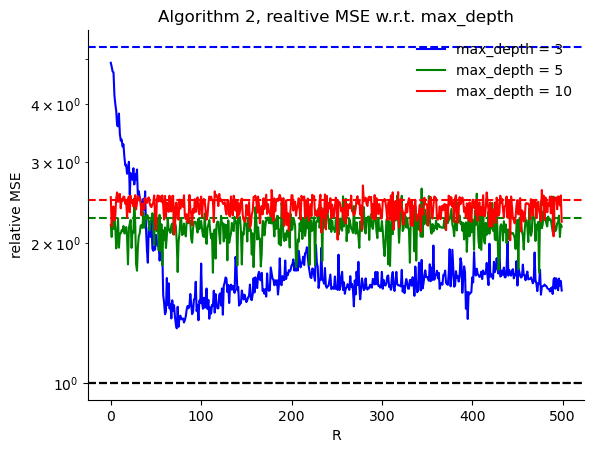

In [52]:
experiment(n_clusters, n_ds, m_i, regenerate=False, max_depths=3)